In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import keras



# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input/dataset/dataset"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['Daisy', 'Windflower', 'Tigerlily', 'Pansy', 'ColtsFoot', 'Bluebell', 'Snowdrop', 'Buttercup', 'Crocus', 'Cowslip', 'LilyValley', 'Fritillary', 'Dandelion', 'Daffodil', 'Iris', 'Sunflower', 'Tulip']


**2.EDA**

In [2]:
#define number image and size
W=H = 224
number_classes = 17
batch_size=32

In [3]:
#get image name
def getname(img_path):
    return img_path.split('/')[-2]

In [4]:
#read image
root_dir = '../input/dataset/dataset'
all_path_imgs = glob.glob(os.path.join(root_dir, '*/*.jpg'))
print(all_path_imgs[0])
np.random.shuffle(all_path_imgs)

imgs = []
labels = []
for img_path in all_path_imgs:
    img = load_img(img_path, target_size=(W,H))
    img = img_to_array(img)
    imgs.append(img)
    
    name = getname(img_path)
    labels.append(name)
train_data = np.array(imgs)
le = LabelEncoder()
y_encode = le.fit_transform(labels)
train_labels = to_categorical(y_encode)



../input/dataset/dataset/Daisy/image_0809.jpg


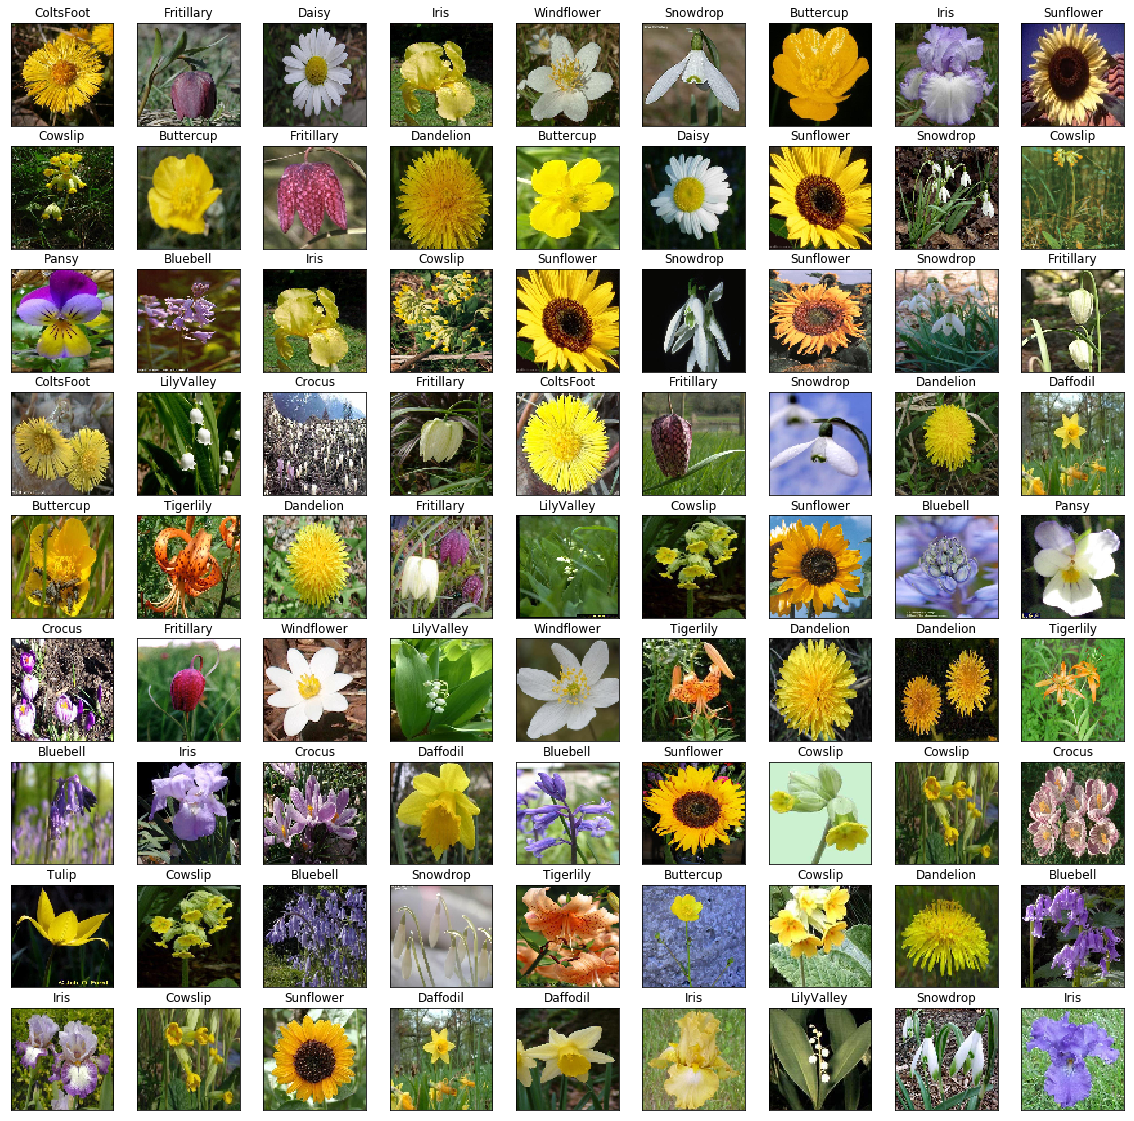

In [5]:
#plot data 
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(20,20))
row = col = 9
for i in range(1, row*col+1):
    k = np.random.randint(1, len(train_data))
    fig.add_subplot(row, col, i)
    img = load_img(all_path_imgs[k], target_size=(80,80))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.title(labels[k])
plt.show()


In [6]:
#train test split 
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(train_data, train_labels, test_size = 0.2, random_state = 16)

In [7]:
#augmentation for train data
aug_train = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0,
                                                         width_shift_range=0.25,
                                                         height_shift_range=0.25,
                                                         brightness_range=(0.5, 2),
                                                         zoom_range=0.5,
                                                         shear_range=0.5,
                                                         horizontal_flip=True)
#augmentation for test data
aug_test = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.0)

**3.Architect**

In [8]:
#load vgg16
vgg = keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=(W,H,3))

vgg_layers = len(vgg.layers)
print('Number vgg layers: '+ str(vgg_layers))

vgg_shape = vgg.output_shape
print('Number vgg_shape: '+ str(vgg_shape))



58892288/58889256 [==============================] - 2s 0us/step
Number vgg layers: 19
Number vgg_shape: (None, 7, 7, 512)


In [9]:
from keras import models
from keras import layers

#define top model
flatten = layers.Flatten()(vgg.output)

fc = layers.Dense(256, activation='relu')(flatten)
fc = layers.Dropout(0.5)(fc)

fc = layers.Dense(number_classes, activation='softmax')(fc)

#new model 
model = models.Model(vgg.input, fc)

In [10]:
#freeze vgg model 
for layer in vgg.layers:
    layer.trainable=False


model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=(['acc']))
network = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train)//batch_size,
                              validation_data=aug_test.flow(X_test, y_test, batch_size),
                              validation_steps=len(X_test)//batch_size,
                              epochs=30)

Epoch 1/30
34/34 [==============================] - 14s 424ms/step - loss: 3.5186 - acc: 0.0882 - val_loss: 2.6140 - val_acc: 0.1523
Epoch 2/30
34/34 [==============================] - 13s 368ms/step - loss: 2.6695 - acc: 0.1296 - val_loss: 2.4405 - val_acc: 0.1333
Epoch 3/30
34/34 [==============================] - 12s 349ms/step - loss: 2.5943 - acc: 0.1553 - val_loss: 2.3714 - val_acc: 0.1917
Epoch 4/30
34/34 [==============================] - 12s 356ms/step - loss: 2.5440 - acc: 0.1590 - val_loss: 2.1420 - val_acc: 0.3125
Epoch 5/30
34/34 [==============================] - 12s 357ms/step - loss: 2.4449 - acc: 0.1921 - val_loss: 2.1243 - val_acc: 0.2583
Epoch 6/30
34/34 [==============================] - 12s 356ms/step - loss: 2.4118 - acc: 0.1829 - val_loss: 2.2093 - val_acc: 0.2125
Epoch 7/30
34/34 [==============================] - 12s 362ms/step - loss: 2.4149 - acc: 0.1590 - val_loss: 1.9795 - val_acc: 0.3292
Epoch 8/30
34/34 [==============================] - 12s 362ms/step - 

In [11]:
#unfreeze vgg model 
for layer in vgg.layers[15:]:
    layer.trainable=True

opt = keras.optimizers.SGD(0.001)
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=(['acc']))
network = model.fit_generator(aug_train.flow(X_train, y_train, batch_size=batch_size),
                              steps_per_epoch=len(X_train)//batch_size,
                              validation_data=aug_test.flow(X_test, y_test, batch_size),
                              validation_steps=len(X_test)//batch_size,
                              epochs=30)

Epoch 1/30
34/34 [==============================] - 13s 391ms/step - loss: 1.8776 - acc: 0.3603 - val_loss: 1.1574 - val_acc: 0.6641
Epoch 2/30
34/34 [==============================] - 12s 361ms/step - loss: 1.7930 - acc: 0.3695 - val_loss: 1.1891 - val_acc: 0.6208
Epoch 3/30
34/34 [==============================] - 12s 361ms/step - loss: 1.8413 - acc: 0.3382 - val_loss: 1.0467 - val_acc: 0.6667
Epoch 4/30
34/34 [==============================] - 13s 374ms/step - loss: 1.8430 - acc: 0.3474 - val_loss: 1.1515 - val_acc: 0.6833
Epoch 5/30
34/34 [==============================] - 12s 366ms/step - loss: 1.8106 - acc: 0.3704 - val_loss: 1.0782 - val_acc: 0.6833
Epoch 6/30
34/34 [==============================] - 12s 365ms/step - loss: 1.7824 - acc: 0.3529 - val_loss: 1.0910 - val_acc: 0.6417
Epoch 7/30
34/34 [==============================] - 12s 360ms/step - loss: 1.8347 - acc: 0.3529 - val_loss: 1.1350 - val_acc: 0.6375
Epoch 8/30
34/34 [==============================] - 12s 359ms/step - 

In [12]:
#visualize 
history_dict = network.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

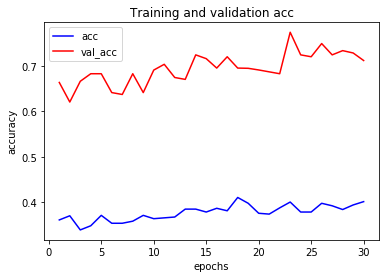

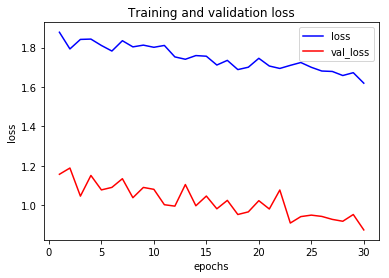

In [13]:
epochs = range(1, len(history_dict['acc'])+1)
plt.plot(epochs, history_dict['acc'], 'b', label='acc')
plt.plot(epochs, history_dict['val_acc'], 'r', label='val_acc')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.title("Training and validation acc")
plt.legend()
plt.figure()
plt.plot(epochs, history_dict['loss'], 'b', label='loss')
plt.plot(epochs, history_dict['val_loss'], 'r', label='val_loss')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and validation loss")
plt.legend()